In [16]:
import numpy as np
import pandas as pd
from scipy.special import log_softmax, softmax
import matplotlib.pyplot as plt
import torch

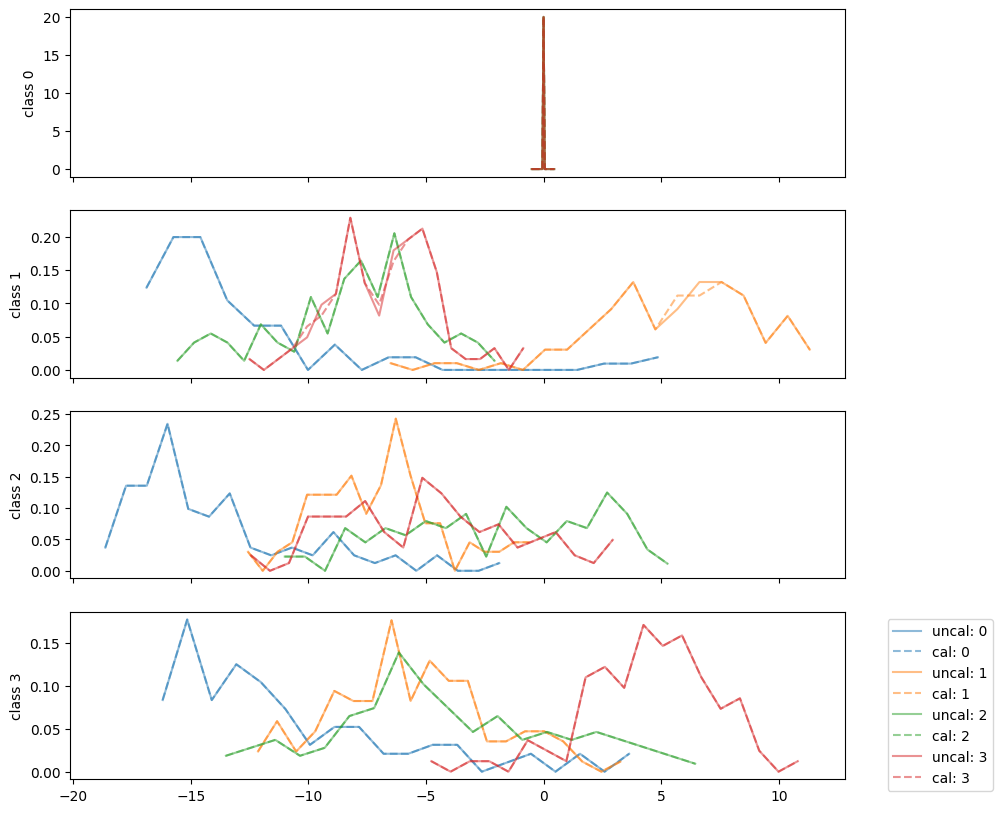

In [17]:
def load_data(dataset, size, seed):
    test_samples = {"sst2": 400, "agnews": 400, "dbpedia": 700}[dataset]
    uncal_logits = pd.read_csv(f'../outputs/finetune_lora/llama3.2-1b-instruct/{dataset}/size={size}/seed={seed}/lora_ans_no_es/0.0-1.0/0.7-1.0/test={dataset}/list=test_{test_samples}/logits.csv', header=None, index_col=0).values.astype(float)
    uncal_logits = log_softmax(uncal_logits, axis=1)
    uncal_labels = pd.read_csv(f'../outputs/finetune_lora/llama3.2-1b-instruct/{dataset}/size={size}/seed={seed}/lora_ans_no_es/0.0-1.0/0.7-1.0/test={dataset}/list=test_{test_samples}/labels.csv', header=None, index_col=0).values.astype(int).flatten()
    cal_logits = pd.read_csv(f'../outputs/lora_plus_tempscaling/llama3.2-1b-instruct/{dataset}/size={size}/seed={seed}/lora_ans_no_es/0.0-1.0/0.7-1.0/0.7-1.0/test={dataset}/list=test_{test_samples}/logits.csv', header=None, index_col=0).values.astype(float)
    cal_logits = log_softmax(cal_logits, axis=1)
    cal_labels = pd.read_csv(f'../outputs/lora_plus_tempscaling/llama3.2-1b-instruct/{dataset}/size={size}/seed={seed}/lora_ans_no_es/0.0-1.0/0.7-1.0/0.7-1.0/test={dataset}/list=test_{test_samples}/labels.csv', header=None, index_col=0).values.astype(int).flatten()
    alpha = float(torch.load(f'../outputs/lora_plus_tempscaling/llama3.2-1b-instruct/{dataset}/size={size}/seed={seed}/lora_ans_no_es/0.0-0.7/0.0-0.3/0.7-1.0/last.ckpt',weights_only=False)["model"]["alpha"])

    uncal_logits_train = pd.read_csv(f'../outputs/finetune_lora/llama3.2-1b-instruct/{dataset}/size={size}/seed={seed}/lora_ans_no_es/0.0-0.7/0.0-0.3/test={dataset}/list=0.7-1.0/logits.csv', header=None, index_col=0).values.astype(float)
    uncal_logits_train = log_softmax(uncal_logits_train, axis=1)
    uncal_labels_train = pd.read_csv(f'../outputs/finetune_lora/llama3.2-1b-instruct/{dataset}/size={size}/seed={seed}/lora_ans_no_es/0.0-0.7/0.0-0.3/test={dataset}/list=0.7-1.0/labels.csv', header=None, index_col=0).values.astype(int).flatten()
    cal_logits_train = log_softmax(uncal_logits_train * alpha, axis=1)
    cal_labeles_train = uncal_labels_train

    
    ce_cal_vs_uncal = -np.mean(np.sum(np.exp(cal_logits_train) * uncal_logits_train, axis=1))
    ce_data_vs_uncal = -np.mean(uncal_logits_train[range(len(uncal_labels_train)), uncal_labels_train])
    
    # print(f"CE(q_hat, q) = {ce_cal_vs_uncal:.4f}")
    # print(f"CE(data, q) = {ce_data_vs_uncal:.4f}")
    # print(f"Rel err = {abs(ce_cal_vs_uncal - ce_data_vs_uncal)/ce_cal_vs_uncal:.4f}")
    # print()
    rel_err = abs(ce_cal_vs_uncal - ce_data_vs_uncal)/ce_cal_vs_uncal
    return uncal_logits, uncal_labels, cal_logits, cal_labels, alpha, rel_err

# rel_err = 0
# # for size in [8, 16, 32, 64, 128, 256]:
# for size in [8]:
#     for seed in range(5):
#         uncal_logits, uncal_labels, cal_logits, cal_labels, alpha, rel_err = load_data("agnews", size, seed)
#         rel_err += rel_err
#         print(alpha)
#     # print(rel_err/5)

# print((~np.isclose(log_softmax(uncal_logits * alpha, axis=1),log_softmax(cal_logits,axis=1))).sum())
# print(alpha)
uncal_logits, uncal_labels, cal_logits, cal_labels, alpha, rel_err = load_data("agnews", 8, 0)
nbins = 20
fig, ax = plt.subplots(uncal_logits.shape[1], 1, figsize=(10, 10), sharex=True)
for i in range(uncal_logits.shape[1]):
    for j in range(uncal_logits.shape[1]):
        # i = j
        # hist, edges = np.histogram(uncal_logits.max(axis=1), bins=nbins, density=True)
        # ax[i].plot(edges[:-1], hist, label=f'winner', alpha=0.5, color=f'k', linestyle=':')
        hist, edges = np.histogram(uncal_logits[uncal_labels==j, i]-uncal_logits[uncal_labels==j, 0], bins=nbins, density=True)
        ax[i].plot(edges[:-1], hist, label=f'uncal: {j}', alpha=0.5, color=f'C{j}', linestyle='-')
        hist, edges = np.histogram(cal_logits[cal_labels==j, i]-cal_logits[cal_labels==j, 0], bins=nbins, density=True)
        ax[i].plot(edges[:-1], hist, label=f'cal: {j}', alpha=0.5, color=f'C{j}', linestyle='--')
    ax[i].set_ylabel(f'class {i}')
    # ax[i].set_xlim(-20, 0)
ax[-1].legend(loc='upper right', bbox_to_anchor=(1.2, 1))


    

1.0


array([<Axes: title={'center': 'Scores from col 0'}>,
       <Axes: title={'center': 'Scores from col 1'}>], dtype=object)

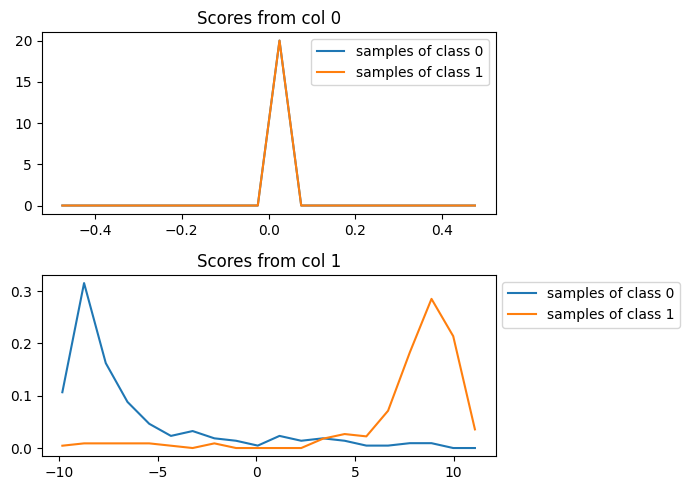

In [29]:
from expected_cost.utils import plot_hists

uncal_logits, uncal_labels, cal_logits, cal_labels, alpha, rel_err = load_data("sst2", 32, 3)
uncal_logits -= uncal_logits[:,0].reshape(-1,1)
print(alpha)
plot_hists(uncal_labels, uncal_logits, nbins=20, group_by='score')

array([<Axes: title={'center': 'Scores from col 0'}>,
       <Axes: title={'center': 'Scores from col 1'}>,
       <Axes: title={'center': 'Scores from col 2'}>,
       <Axes: title={'center': 'Scores from col 3'}>], dtype=object)

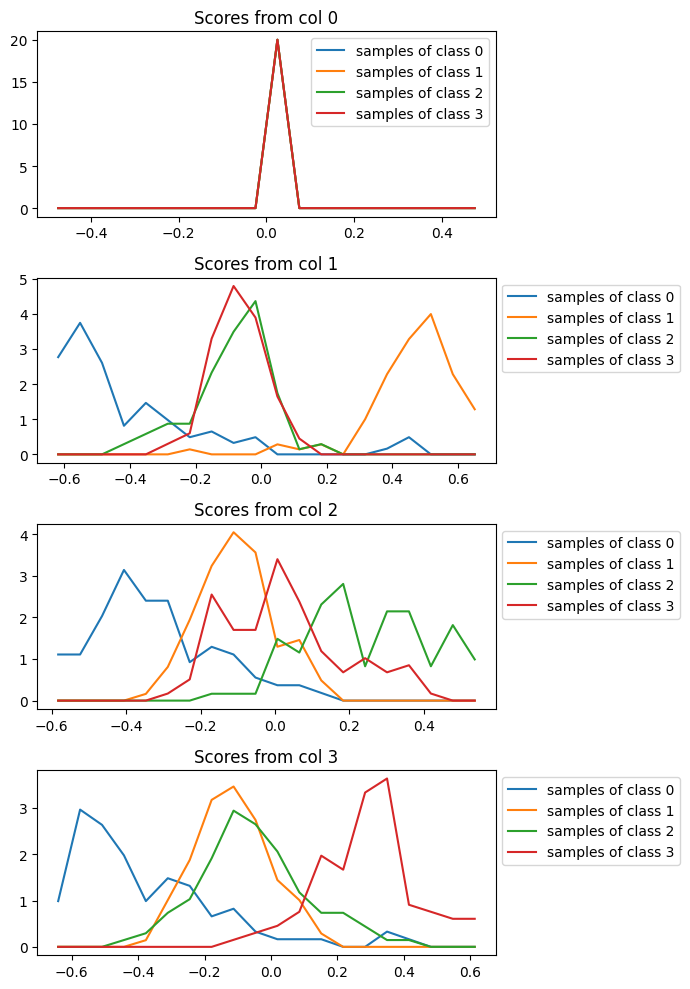

In [19]:
uncal_logits, uncal_labels, cal_logits, cal_labels, alpha, rel_err = load_data("agnews", 8, 2)
cal_logits -= cal_logits[:,0].reshape(-1,1)
plot_hists(cal_labels, cal_logits, nbins=20, group_by='score')